In [1]:
import numpy as np
import pandas as pd
import thermo
import chemicals
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, FlashPureVLS, VaporPressure, PropertyCorrelationsPackage
from thermo import FlashVLN, ViscosityLiquidMixture, ViscosityGasMixture, SurfaceTensionMixture, FlashVL, Mixture
import matplotlib.pyplot as plt
from thermo.interaction_parameters import IPDB
import pint
from thermo import PR

ureg = pint.UnitRegistry()

C:\Users\EricKim\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


https://www.youtube.com/watch?v=pQFBmqbsh9Y&ab_channel=AliAl-Matar

https://www.researchgate.net/figure/Phase-envelopes-for-propane-methane-mixtures_fig12_241789652

https://www.chem.mtu.edu/chem_eng/faculty/memullins/course/BubblePoint/Bubble%20Point.htm

https://thermo.readthedocs.io/activity_coefficients.html

https://thermo.readthedocs.io/property_objects.html

https://www3.nd.edu/~markst/bas2000.pdf

https://scholarhub.ui.ac.id/cgi/viewcontent.cgi?article=1331&context=science

http://www.coolprop.org/dev/fluid_properties/Mixtures.html#phase-envelope

https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.690320819

https://www.researchgate.net/publication/229885780_A_new_method_for_critical_points_calculation_from_cubic_EOS

## I got vapor P calculation for pure component, Figure out for mixture using Van Laar activity coefficients

In [2]:
def cas_to_name(cas):
    if not isinstance(cas, str):
        raise ValueError("Input must be a string")    
    return ChemicalConstantsPackage.constants_from_IDs([cas]).names[0]

def name_to_cas(name):
    if not isinstance(name, str):
        raise ValueError("Input must be a string")    
    return ChemicalConstantsPackage.constants_from_IDs([name]).CASs[0]

def F_to_R(F):
    return F + 459.67

def R_to_F(R):
    return R - 459.67

def C_to_K(C):
    return C + 273.15

def F_to_C(F):
    return (F - 32) * 5 / 9

def K_to_C(K):
    return K - 273.15

def gal_to_bbl(gal):
    return gal / 42

def bbl_to_gal(bbl):
    return bbl * 42

def psi_to_Pa(psi):
    return psi * 6894.745

def Pa_to_bar(Pa):
    return Pa / 100000

def Pa_to_psi(pa):
    return pa / 6894.745

def Pa_to_mmHg(Pa):
    return Pa / 133.322

def mmHg_to_Pa(mmHg):
    return mmHg / 0.0075

def F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def K_to_F(K):
    return (K - 273.15) * 1.8 + 32

In [3]:
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, PropertyCorrelationsPackage
from thermo import FlashVLN
import matplotlib.pyplot as plt
from thermo.interaction_parameters import IPDB

In [4]:
def calculate_ai_bi(R, Tci, Pci):
    ai = 0.45724 * R**2 * Tci**2 / Pci
    bi = 0.07780 * R * Tci / Pci
    return ai, bi

In [5]:
def calculate_amizs_bmizs(R, Tcs, Pcs, zs, kijs):

    n = len(Tcs)

    a = [0.45724 * (R ** 2) * (Tcs[i] ** 2) / Pcs[i] for i in range(n)]
    b = [0.07780 * R * Tcs[i] / Pcs[i] for i in range(n)]

    a_mizs = sum(zs[i] * zs[j] * (a[i] * a[j]) ** 0.5 * (1 - kijs[i][j]) for i in range(n) for j in range(n))
    b_mizs = sum(zs[i] * b[i] for i in range(n))

    return a_mizs, b_mizs

In [10]:
comp = dict([
    ('methane', 0.5), 
    ('ethane', 0.5),
])
zs = list(comp.values())

In [11]:
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')
kijs

[[0.0, -0.0059], [-0.0059, 0.0]]

In [12]:
Tcs = constants.Tcs
Pcs = constants.Pcs
omegas = constants.omegas

In [13]:
R = 8.314 * 1000
amix, bmix = calculate_amizs_bmizs(R, Tcs, Pcs, zs, kijs)

In [51]:
8 * amix / (27 * R * bmix)

432.88789575030944

In [57]:
Pa_to_psi(amix / (27 * bmix ** 2))

1938.0528957263136

In [70]:
obj = PRMIX(Tcs=Tcs, Pcs=Pcs, omegas=omegas, zs=zs, kijs=kijs, T=200, P=psi_to_Pa(300))
obj.mechanical_critical_point()

(251.79475243203058, 4837540.914767563)

In [72]:
obj.pseudo_Tc

247.94299999999998

In [59]:
sum(obj.a_alphas_vectorized(T))

0.8370746152457968

In [48]:
from scipy.optimize import fsolve
import numpy as np

def calculate_amix_bmizs(R, Tcs, Pcs, zs, kijs):
    n = len(Tcs)
    a = [0.45724 * (R ** 2) * (Tcs[i] ** 2) / Pcs[i] for i in range(n)]
    b = [0.07780 * R * Tcs[i] / Pcs[i] for i in range(n)]
    a_mizs = sum(zs[i] * zs[j] * (a[i] * a[j]) ** 0.5 * (1 - kijs[i][j]) for i in range(n) for j in range(n))
    b_mizs = sum(zs[i] * b[i] for i in range(n))
    return a_mizs, b_mizs

def critical_conditions(vars, R, Tcs, Pcs, zs, kijs):
    T, V = vars
    a_mix, b_mix = calculate_amix_bmizs(R, Tcs, Pcs, zs, kijs)
    alpha = np.array([1 + (1 - np.sqrt(T / Tcs[i])) for i in range(len(Tcs))])  # Assuming α = 1 for simplification

    # First derivative of PR EOS
    dPdV = R * T / (V - b_mix)**2 - a_mix / (V * (V + b_mix) + b_mix * (V - b_mix))**2

    # Second derivative of PR EOS
    d2PdV2 = -2 * R * T / (V - b_mix)**3 + 2 * a_mix * (V**2 + 4 * V * b_mix - b_mix**2) / (V * (V + b_mix) + b_mix * (V - b_mix))**3

    return [dPdV, d2PdV2]

# Universal Gas Constant in J/(mol·K)
R_Pa = 8.314

# Critical properties and acentric factors for Methane (CH4) and Ethane (C2H6)
Tcs = [190.56, 305.32]  # K
Pcs = [45.99e5, 48.72e5]  # Pa
zs = [0.5, 0.5]  # 50:50 Mixture
kijs = [[0.0, -0.0059], [-0.0059, 0.0]]

# Initial guess for Tc and Vc (average of critical temperatures and volumes)
Tc_guess = sum(zs[i] * Tcs[i] for i in range(len(Tcs)))
Vc_guess = sum(zs[i] * (R_Pa * Tcs[i] / Pcs[i]) for i in range(len(Tcs))) / len(Tcs)



# Solve for Tc and Vc
Tc, Vc = fsolve(critical_conditions, [Tc_guess, Vc_guess], args=(R_Pa, Tcs, Pcs, zs, kijs))
Tc, Vc

C:\Users\EricKim\AppData\Local\Temp\ipykernel_7760\22892256.py:15: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.array([1 + (1 - np.sqrt(T / Tcs[i])) for i in range(len(Tcs))])  # Assuming α = 1 for simplification


(-7.138572826193013e-06, 13779.702470424656)

In [49]:
Tc_guess

247.94

In [50]:
8 * amix / (27 )

3271605.032556764

In [66]:
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

HEOS = CP.AbstractState('HEOS', 'Methane&Ethane')
x0 = 0.5

HEOS.set_mole_fractions([x0, 1 - x0])
HEOS.build_phase_envelope("dummy")
PE = HEOS.get_phase_envelope_data()

In [70]:

attrs = vars(PE)
# {'kids': 0, 'name': 'Dog', 'color': 'Spotted', 'age': 10, 'legs': 2, 'smell': 'Alot'}
# now dump this in some way or another
print(', '.join("%s: %s" % item for item in attrs.items()))

TypeError: vars() argument must have __dict__ attribute

In [72]:
PE

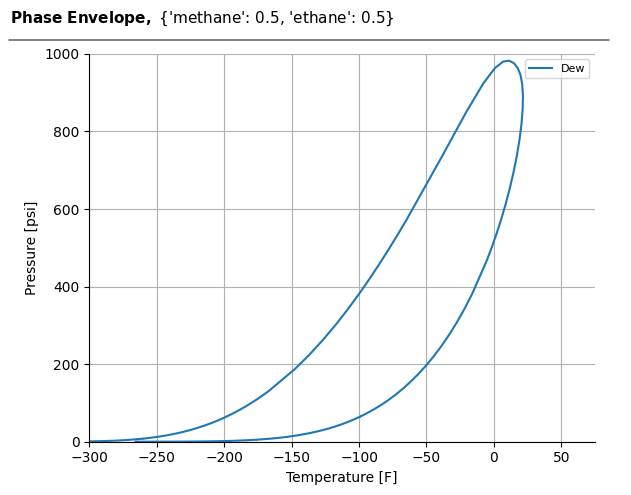

In [65]:
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

HEOS = CP.AbstractState('HEOS', 'Methane&Ethane')
x0 = 0.5

HEOS.set_mole_fractions([x0, 1 - x0])
HEOS.build_phase_envelope("dummy")
PE = HEOS.get_phase_envelope_data()

fig, ax = plt.subplots(figsize=(6, 5))

x = PE.T
x = [K_to_F(item) for item in x]

T_unit = 'F'
#T_crit = res.pseudo_Tc()
#T_crit = K_to_F(res.pseudo_Tc())

#P_crit = res.pseudo_Pc()
#P_crit = Pa_to_psi(res.pseudo_Pc())

PE.p

P_dews_plot = [Pa_to_psi(item) for item in PE.p]
P_unit ='psi'

#ax.scatter(T_crit, P_crit, s=100)

ax.plot(x, P_dews_plot, label='Dew')
#ax.plot(x, P_bubbles_plot, label='Bubble')

ax.set_xlabel('Temperature [%s]' % T_unit)
ax.set_ylabel('Pressure [%s]' % P_unit)

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(ncol=2, fontsize=8)
    
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

comp = {k: round(v, 2) for k, v in comp.items()}

bold_txt = setbold('Phase Envelope, ')
plain_txt = str(comp)
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(-300, 75)
ax.set_ylim(0, 1000)

fig.tight_layout()

In [5]:
def psi_to_Pa(psi):
    return psi * 6894.745

def F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def Pa_to_psi(pa):
    return pa / 6894.745

def K_to_F(K):
    return (K - 273.15) * 1.8 + 32

comp = dict([
    ('oxygen', 0.21),
    ('nitrogen', 0.78),
    ('argon', 0.01),
])
comp = dict([
    ('methane', 0.2), 
    ('propane', 0.2),
    ('hexane', .6),
    ('water', 0.),
])

total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs)
#eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas)
gas = CEOSGas(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
liq = CEOSLiquid(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
flashN = FlashVLN(constants, properties, liquids=[liq, liq], gas=gas) # if dealing with water, fill [liq, liq] twice.
flashN = FlashVL(constants, properties, liquid=liq, gas=gas) # if dealing with water, fill [liq, liq] twice.

P = psi_to_Pa(100)
T = F_to_K(100)

res = flashN.flash(T=T, P=P, zs=list(comp.values()))
zs = list(comp.values())

In [6]:
eos_kwargs

{'Tcs': [190.564, 369.89, 507.82, 647.096],
 'Pcs': [4599200.0, 4251200.0, 3044100.0, 22064000.0],
 'omegas': [0.01142, 0.1521, 0.3, 0.3443],
 'kijs': [[0.0, 0.0119, 0.04, 0],
  [0.0119, 0.0, 0.0007, 0],
  [0.04, 0.0007, 0.0, 0],
  [0, 0, 0, 0.0]]}

In [7]:
comp = dict([
    ('CO2', 0.2), 
    ('N2', 0.2),
    ('H2S', 0.6),
    ('CH4', 0.6),
    ('C6H14', 0.6),
])
#comp = dict([
#    ('methane', 0.5), 
#    ('ethane', 0.5),
#])

total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
zs = list(comp.values())
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')
eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs, zs=zs)

P = 100000

Tbs = m.Tbs
Tcs = m.Tcs
Pcs = m.Pcs
omegas = m.omegas

T = 300

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs, zs=zs)
PR_obj = PRMIX(**eos_kwargs, P=P, T=T)

Pa_to_bar(VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0], eos=PR_obj).calculate(T, 'SANJARI'))

NameError: name 'm' is not defined

In [190]:
kijs

[[0.0, -0.0122, 0.0967, 0.0978, 0.11],
 [-0.0122, 0.0, 0.1652, 0.0289, 0.1496],
 [0.0967, 0.1652, 0.0, 0, 0],
 [0.0978, 0.0289, 0, 0.0, 0.04],
 [0.11, 0.1496, 0, 0.04, 0.0]]

In [130]:
zs = [0.2, 0.2, 0.6]

P = psi_to_Pa(100)
T = F_to_K(100)

mix = ['methane', 'toluene', 'm-Xylene']

Tbs = Mixture(mix, zs=zs).Tbs
Tcs = Mixture(mix, zs=zs).Tcs
Pcs = Mixture(mix, zs=zs).Pcs
omegas = Mixture(['benzene', 'toluene', 'm-Xylene'], zs=zs).omegas


PR_obj = PRMIX(Tcs=Tcs, Pcs=Pcs, omegas=omegas, zs=zs, P=P, T=T, kijs=kijs)

In [138]:
VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0]).calculate(T, 'SANJARI')

153675109.74916753

In [139]:
VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0], eos=PR_obj).calculate(T, 'SANJARI')

153675109.74916753

In [111]:
Mixture(mix, zs=zs).fgcs

AttributeError: 'Mixture' object has no attribute 'fgcs'

In [110]:
Tcs

[190.564, 591.75, 616.89]

In [106]:
zs

[0.2, 0.2, 0.6, 0.0]

In [104]:
zs

[0.2, 0.2, 0.6, 0.0]

In [99]:
Tcs

190.564

In [ ]:
fig = flashN.plot_TP(zs=zs, show=False)
ax = fig.get_axes()[0]
ax.set_yscale('linear')

fig.savefig('PT.png')

In [6]:
Tcs = np.array((res.Tcs))
zss = np.array(zs)
sum(Tcs * zss)

416.7828

In [7]:
res.pseudo_Tc()

416.7828

In [8]:
res.CASs

['74-82-8', '74-98-6', '110-54-3', '7732-18-5']

In [85]:
T = F_to_K(72.5)
T = C_to_K(-70)

Pa_to_psi(Mixture(['methane', 'propane'], ws=[0.5, 0.5], T=T).Pbubble)

747.7472372660187

In [97]:
name_to_cas('methane')

'74-82-8'

In [125]:
VaporPressure(Tb=Tbs, Tc=Tcs, Pc=Pcs, omega=omegas, eos=PR_obj).calculate(T, 'SANJARI')

92870952.05962054

In [126]:
VaporPressure(Tb=Tbs, Tc=Tcs, Pc=Pcs, omega=omegas).calculate(T, 'SANJARI')

92870952.05962054

In [93]:
Mixture(['methane', 'propane'], ws=[0.5, 0.5], T=T).CASs

['74-82-8', '74-98-6']

In [122]:
for t in range(-100, 25, 5):
    T = C_to_K(t)

    mix = ['methane', 'toluene', 'm-Xylene']

    Tbs = Mixture(mix, ws=[0.2, 0.2, 0.6]).Tbs[0]
    Tcs = Mixture(mix, ws=[0.2, 0.2, 0.6]).Tcs[0]
    Pcs = Mixture(mix, ws=[0.2, 0.2, 0.6]).Pcs[0]
    omegas = Mixture(['benzene', 'toluene', 'm-Xylene'], ws=[0.2, 0.2, 0.6]).omegas[0]

    vp = Pa_to_psi(VaporPressure(Tb=Tbs, Tc=Tcs, Pc=Pcs, omega=omegas).calculate(T, 'SANJARI'))
    
    print('T = %d C, Vp = %.3f' % (K_to_C(T), vp))

T = -100 C, Vp = 342.822
T = -95 C, Vp = 419.340
T = -90 C, Vp = 508.209
T = -85 C, Vp = 610.910
T = -80 C, Vp = 729.123
T = -75 C, Vp = 864.757
T = -70 C, Vp = 1019.993
T = -65 C, Vp = 1197.334
T = -60 C, Vp = 1399.658
T = -55 C, Vp = 1630.283
T = -50 C, Vp = 1893.041
T = -45 C, Vp = 2192.365
T = -40 C, Vp = 2533.395
T = -35 C, Vp = 2922.092
T = -30 C, Vp = 3365.386
T = -25 C, Vp = 3871.338
T = -20 C, Vp = 4449.344
T = -15 C, Vp = 5110.366
T = -10 C, Vp = 5867.214
T = -5 C, Vp = 6734.876
T = 0 C, Vp = 7730.921
T = 5 C, Vp = 8875.967
T = 10 C, Vp = 10194.253
T = 15 C, Vp = 11714.317
T = 20 C, Vp = 13469.817


In [89]:
Tcs

190.564

In [68]:
Pa_to_bar(VaporPressure(Tb=Tbs, Tc=Tcs, Pc=Pcs, omega=omegas).calculate(T, 'SANJARI'))

23.636698659822535

In [15]:
Mixture(['methane', 'propane'], ws=[0.5, 0.5], T=T).Pbubble

250300919.66963524

In [18]:
Mixture(['methane', 'propane'], ws=[0.5, 0.5], T=T).Psats

[341038236.1417108, 892897.0239571161]

In [19]:
Mixture(['benzene', 'toluene'], ws=[0.5, 0.5], T=320).Psats

[32069.698020585838, 10726.733206586498]

In [10]:
Pa_to_psi(res.pseudo_Pc())

521.6349553174193

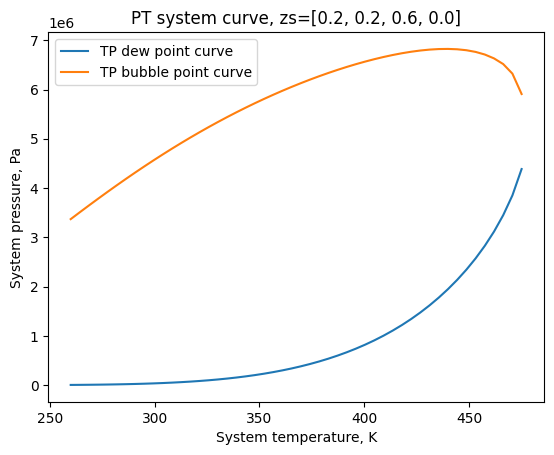

In [164]:
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, PropertyCorrelationsPackage
from thermo import FlashVLN
import matplotlib.pyplot as plt
from thermo.interaction_parameters import IPDB

def psi_to_Pa(psi):
    return psi * 6894.745

def F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def Pa_to_psi(pa):
    return pa / 6894.745

def K_to_F(K):
    return (K - 273.15) * 1.8 + 32

comp = dict([
('methane', 0.2),
('propane', 0.2),
('hexane', .6),
('water', 0.),
])

total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs)
gas = CEOSGas(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
liq = CEOSLiquid(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
flashN = FlashVLN(constants, properties, liquids=[liq, liq], gas=gas) # if dealing with water, fill [liq, liq] twice.

P = psi_to_Pa(100)
T = F_to_K(100)

res = flashN.flash(T=T, P=P, zs=list(comp.values()))

zs = list(comp.values())

#fig = flashN.plot_TP(zs=zs, show=False)
#ax = fig.get_axes()[0]
#ax.set_yscale('linear')
fig = flashN.plot_TP(zs=zs, show=False, Tmin=260, Tmax=475, pts=50, hot=True)
ax = fig.get_axes()[0]
ax.set_yscale('linear')

In [167]:
Ts, P_dews, P_bubbles, branch_Ps = flashN.plot_TP(zs=zs, show=False, Tmin=100, Tmax=475, pts=50, hot=True, values=True)
Ts2, P_dews2, P_bubbles2, branch_Ps2 = flashN.plot_TP(zs=zs, show=False, Tmin=260, Tmax=475, pts=50, hot=True, values=True)

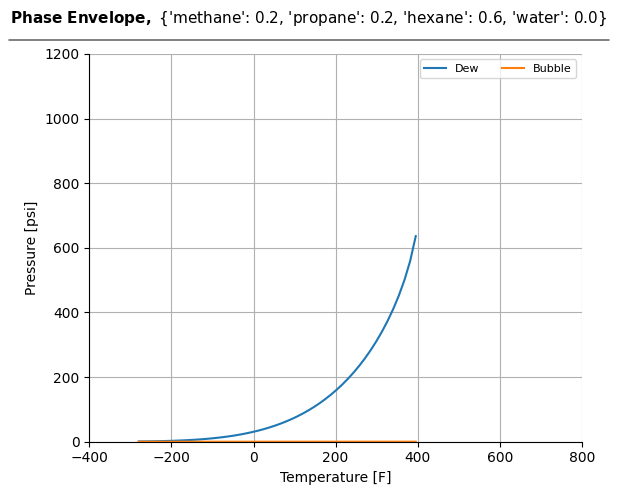

In [169]:
fig, ax = plt.subplots(figsize=(6, 5))

x = Ts
x = [K_to_F(item) for item in x]

T_unit = 'F'
T_crit = res.pseudo_Tc()
T_crit = K_to_F(res.pseudo_Tc())

P_dews = [Pa_to_psi(item) for item in P_dews2]
P_bubbles = [Pa_to_psi(item) for item in P_bubbles]
P_unit ='psi'

ax.plot(x, P_dews, label='Dew')
ax.plot(x, P_bubbles, label='Bubble')

ax.set_xlabel('Temperature [%s]' % T_unit)
ax.set_ylabel('Pressure [%s]' % P_unit)

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(ncol=2, fontsize=8)
    
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

comp = {k: round(v, 2) for k, v in comp.items()}

bold_txt = setbold('Phase Envelope, ')
plain_txt = str(comp)
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(-400, 800)
ax.set_ylim(0, 1200)

fig.tight_layout()

In [155]:
dew_y = ax.lines[0].get_ydata()
dew_x = ax.lines[0].get_xdata()

bubble_y = ax.lines[1].get_ydata()
bubble_x = ax.lines[1].get_xdata()

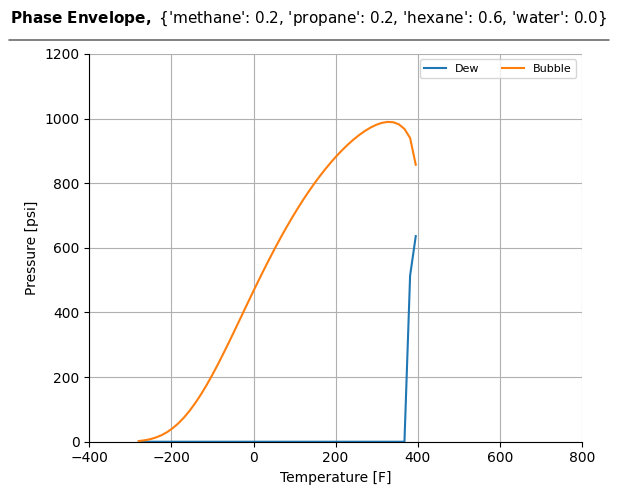

In [158]:
#Ts, P_dews, P_bubbles, branch_Ps = flashN.plot_TP(zs=zs, show=False, values=True, pts=50, hot=True)

P_dews = dew_y
P_bubbles = bubble_y

res = flashN.flash(T=T, P=P, zs=list(comp.values()))

fig, ax = plt.subplots(figsize=(6, 5))

x1 = dew_x
x2 = bubble_x

x1 = [K_to_F(item) for item in x1]
x2 = [K_to_F(item) for item in x2]

T_unit = 'F'
#T_crit = res.pseudo_Tc()
#T_crit = K_to_F(res.pseudo_Tc())

P_dews = [Pa_to_psi(item) for item in P_dews]
P_bubbles = [Pa_to_psi(item) for item in P_bubbles]
P_unit ='psi'

ax.plot(x1, P_dews, label='Dew')
ax.plot(x2, P_bubbles, label='Bubble')

ax.set_xlabel('Temperature [%s]' % T_unit)
ax.set_ylabel('Pressure [%s]' % P_unit)

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(ncol=2, fontsize=8)
    
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

comp = {k: round(v, 2) for k, v in comp.items()}

bold_txt = setbold('Phase Envelope, ')
plain_txt = str(comp)
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(-400, 800)
ax.set_ylim(0, 1200)

fig.tight_layout()

In [129]:
comp = dict([
    ('ethanol', .5),
    ('hexane', 0.5),
])

zs = list(comp.values())

Pa_to_mmHg(Mixture(list(comp.keys()), ws=zs, T=331).Pbubble)

393.074834441059

In [142]:
Ts, P_dews, P_bubbles, branch_Ps = flashN.plot_TP(zs=zs, show=False, values=True, hot=True)

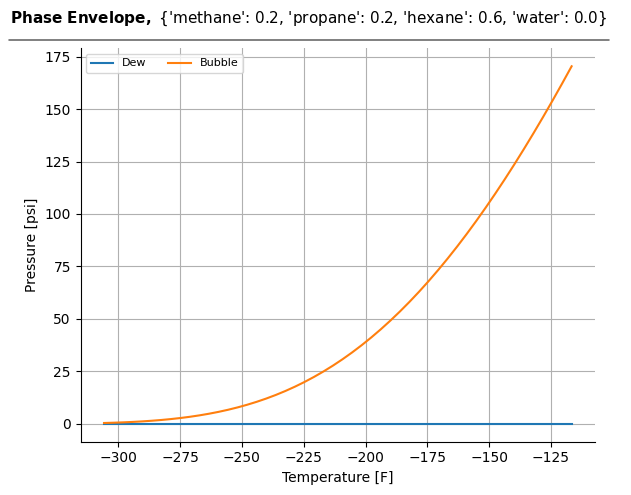

In [143]:
Ts, P_dews, P_bubbles, branch_Ps = flashN.plot_TP(zs=zs, show=False, values=True, pts=50, hot=True)


res = flashN.flash(T=T, P=P, zs=list(comp.values()))

fig, ax = plt.subplots(figsize=(6, 5))

x = Ts
x = [K_to_F(item) for item in x]
T_unit = 'F'
#T_crit = res.pseudo_Tc()
#T_crit = K_to_F(res.pseudo_Tc())

P_dews = [Pa_to_psi(item) for item in P_dews]
P_bubbles = [Pa_to_psi(item) for item in P_bubbles]
P_unit ='psi'

ax.plot(x, P_dews, label='Dew')
ax.plot(x, P_bubbles, label='Bubble')

ax.set_xlabel('Temperature [%s]' % T_unit)
ax.set_ylabel('Pressure [%s]' % P_unit)

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(ncol=2, fontsize=8)
    
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

comp = {k: round(v, 2) for k, v in comp.items()}

bold_txt = setbold('Phase Envelope, ')
plain_txt = str(comp)
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

fig.tight_layout()

In [65]:
Ts, P_dews, P_bubbles, branch_Ps = flashN.plot_TP(zs=zs, show=False, values=True)

In [20]:
res

EquilibriumState(T=310.92777777777775, P=689474.5, zs=[0.2, 0.2, 0.6, 0.0], betas=[0.2747350826525651, 0.7252649173474349], gas=<CEOSGas, T=310.928 K, P=689474 Pa>, liquids=[CEOSLiquid(eos_class=PRMIX, eos_kwargs={"Tcs": [190.564, 369.89, 507.82, 647.096], "Pcs": [4599200.0, 4251200.0, 3044100.0, 22064000.0], "omegas": [0.01142, 0.1521, 0.3, 0.3443]}, HeatCapacityGases=[HeatCapacityGas(CASRN="74-82-8", MW=16.04246, similarity_variable=0.3116728980468083, extrapolation="linear", method="HEOS_FIT", tabular_data={'VDI_TABULAR': ([111.67, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 185.0, 190.0], [34.68379852, 36.78536078, 38.83879566, 41.88686306, 46.65147368, 54.84917074, 71.53332914, 121.50559204, 217.00635642, 2258.9387926]), 'JANAF': ([0.0, 100.0, 200.0, 250.0, 298.15, 300.0, 350.0, 400.0, 450.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 2800.0,

In [77]:
VaporPressure(CASRN='')

thermo.vapor_pressure.VaporPressure

In [38]:
type(Mixture(['benzene', 'toluene', 'm-Xylene'], ws=[0.2, 0.2, 0.6]).CASs)

list